# Flood Index Prediction H20 Resilience. Grainger

## import necessary libraries

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import math
import pandas as pd
from torch import nn

## Get Longitude and Latitude from image pixel

In [73]:
import rasterio

# open the raster dataset
ds = rasterio.open("landuse.tif")

# get the longitude and latitude of the point
lon, lat = ds.xy(55, 3999)

print(f"The longitude and latitude of the random point ({lon}, {lat}).")
# print the bounding box of the dataset
print(ds.bounds)

The longitude and latitude of the random point (-87.7107655089372, 42.084790733276655).
BoundingBox(left=-88.12076525987973, bottom=41.68042918368474, right=-87.60820150073167, top=42.090480191003195)


## Loading and flatenning Geotif Images

In [74]:
# img = rasterio.open('FloodSusceptibilityIndex_3.tif')
landuse = rasterio.open("landuse.tif")
riverine_index = rasterio.open("riverine_index.tif")
BFE = rasterio.open("BFE.tif")
flood_index = rasterio.open("flood_index.tif")

In [75]:
print("landuse shape:", landuse.shape)
print(type(landuse.read()))
landuse_array = landuse.read()
print(landuse_array.shape)

landuse shape: (4000, 5000)
<class 'numpy.ndarray'>
(3, 4000, 5000)


In [76]:
# flattening the RGB bands into a single dimension
landuse = np.mean(landuse.read(), axis=0)
riverine_index = np.mean(riverine_index.read(), axis=0)
BFE = np.mean(BFE.read(), axis=0)
flood_index = np.mean(flood_index.read(), axis=0)

## Visualization of unprocessed images

In [6]:
## Visualizing Data
# banduse = 255 - landuse
# banduse = banduse / 255
# # plot the single channel
# # get axis object with 5 rows and 1 column
# fig, axes = plt.subplots(2, 2, figsize=(20, 16))
# axes[0][0].imshow(landuse, cmap="copper", alpha=0.5)
# axes[0][0].imshow(landuse, cmap="terrain", alpha=0.5)
# axes[0][0].imshow(landuse, cmap="gray", alpha=0.7)
# axes[0][0].imshow(banduse, cmap="terrain", alpha=0.2)
# axes[0][0].set_title("Landuse")

# axes[0][1].imshow(flood_index, cmap="Blues")
# axes[0][1].set_title("Flood Index")
# axes[1][0].imshow(riverine_index, cmap="terrain")
# axes[1][0].set_title("Riverine Index")
# axes[1][1].imshow(BFE, cmap="Reds")
# axes[1][1].set_title("BFE")
# plt.show()
# # plt.imshow(landuse, cmap='Greens', alpha=0.2)
# # set figure size
# plt.figure(figsize=(20, 20))
# plt.imshow(landuse, cmap="copper", alpha=0.5)
# plt.imshow(landuse, cmap="terrain", alpha=0.5)
# plt.imshow(landuse, cmap="gray", alpha=0.7)
# plt.imshow(banduse, cmap="terrain", alpha=0.2)

## Preprocessing Maps

### Preprocessing  and Separating Flood Index mask into 10 separate masks

In [77]:
# Inverting the images so that the water bodies are white
flood_index = flood_index.astype(np.float32)
flood_index = 255 - flood_index  # inversion

In [78]:
# replace all the values to be from 0 to 9. i.e. 10 classes
unique_values = np.unique(flood_index)
print(unique_values)
for i in range(len(unique_values)):
    flood_index[flood_index == unique_values[i]] = i
unique_values = np.unique(flood_index)
print(unique_values)

[  0.        20.333328  38.33333   56.33333   74.66667   92.66667
 111.33333  129.33334  147.66666  165.33334  183.      ]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Text(0.5, 1.0, 'Flood Index')

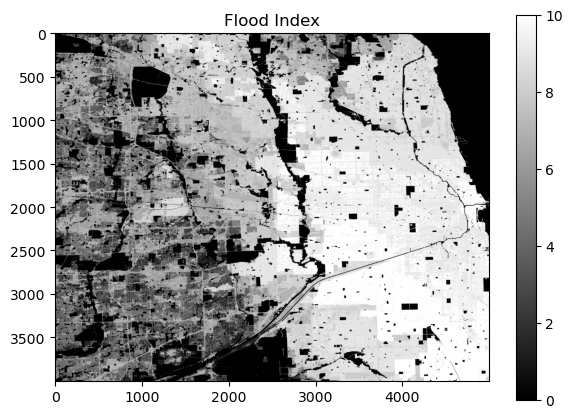

In [79]:
# plot flood index
plt.figure(figsize=(7, 5))
plt.imshow(flood_index, cmap="gray")
cbar = plt.colorbar()
plt.title("Flood Index")

[0. 1.]


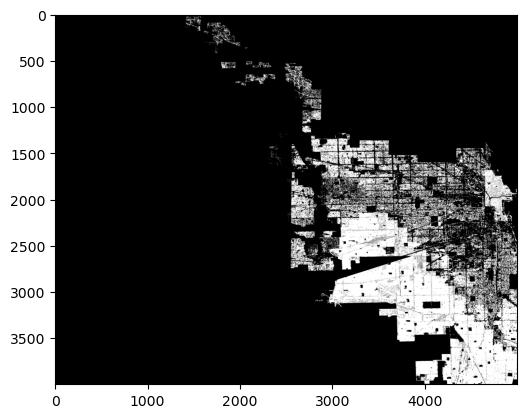

In [80]:
mask_index = flood_index == 10
plt.imshow(mask_index, cmap="gray")
# convert the mask to float 32
mask_index = mask_index.astype(np.float32)
unique_values = np.unique(mask_index)
print(unique_values)

10


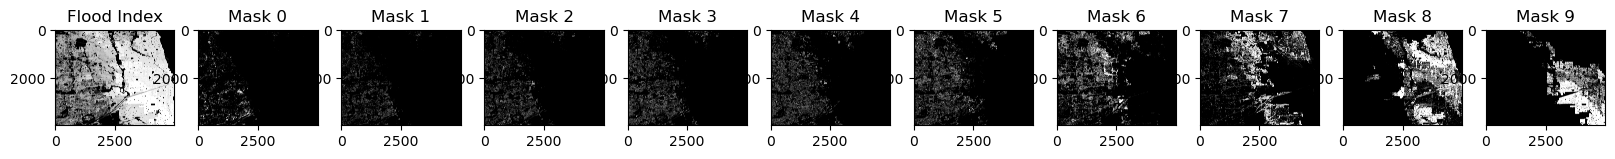

In [31]:
# separate the flood index into 10 different masks
unique_values = np.unique(flood_index)
flood_masks = [
    (flood_index == v).astype(np.float32) for v in range(1, len(unique_values))
]
print(len(flood_masks))
# plot the flood index and the masks
fig, axes = plt.subplots(1, len(unique_values), figsize=(20, 20))
axes[0].imshow(flood_index, cmap="gray")
axes[0].set_title("Flood Index")
for i in range(len(flood_masks)):
    axes[i + 1].imshow(flood_masks[i], cmap="gray")
    axes[i + 1].set_title(f"Mask {i}")

(4000, 5000)
11


Text(0.5, 1.0, 'Flood Index Reconstructed')

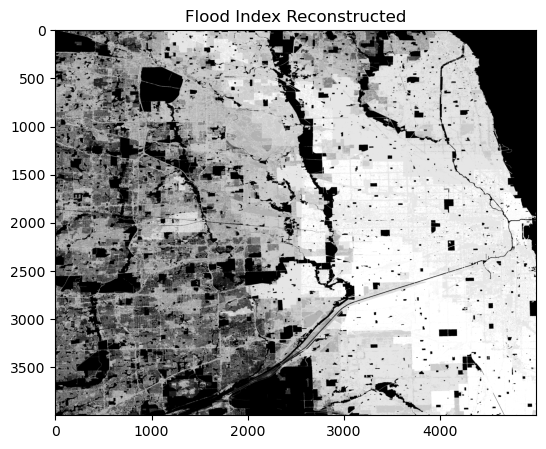

In [81]:
# add the flood masks together to get the original flood index and plot it
i = 1
flood_index_reconstructed = np.zeros(flood_masks[0].shape)
for mask in flood_masks:
    flood_index_reconstructed += mask * i / 10
    i += 1
print(flood_index_reconstructed.shape)
print(i)

plt.figure(figsize=(7, 5))
plt.imshow(flood_index_reconstructed, cmap="gray")
plt.title("Flood Index Reconstructed")

### Inverted Basal Flood elevation Map

In [12]:
BFE = BFE.astype(np.float32)
BFE = 255 - BFE

In [13]:
unique_values = np.unique(BFE)
print(unique_values)
for i in range(len(unique_values)):
    BFE[BFE == unique_values[i]] = i
print(np.unique(BFE))

[  0.  24. 121. 219. 255.]
[0. 1. 2. 3. 4.]


In [14]:
BFE = BFE / np.max(BFE)

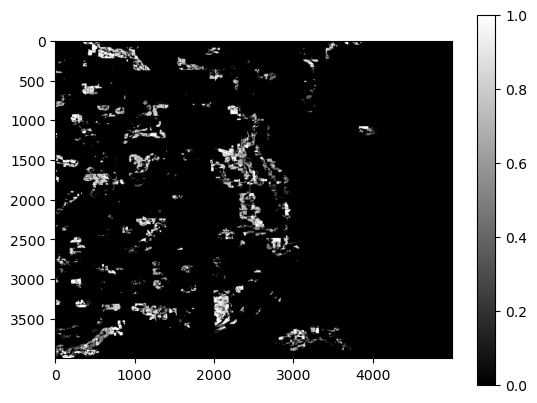

In [15]:
plt.imshow(BFE, cmap="gray")
plt.colorbar()

### inverted landuse map

In [16]:
landuse = landuse.astype(np.float32)
landuse = 255 - landuse

In [17]:
unique_values = np.unique(landuse)
print(unique_values)
for i in range(len(unique_values)):
    landuse[landuse == unique_values[i]] = i
print(np.unique(landuse))

[  0.        5.       25.       30.       55.       58.       92.
  94.       95.      105.      105.33333 114.      117.33333 123.
 129.66666 133.      145.      159.      176.      199.      255.     ]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


In [18]:
landuse = landuse / np.max(landuse)

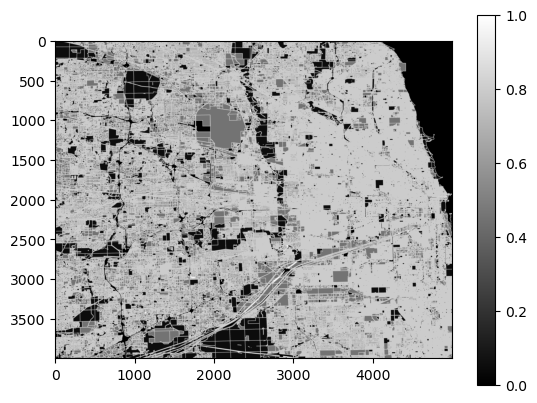

In [19]:
plt.imshow(landuse, cmap="gray")
plt.colorbar()

### inverted riverine map

Inversion is not needed for the riverine data

In [20]:
# load riverine index flatten the RGB bands into a single dimension
# img = rasterio.open('FloodSusceptibilityIndex_3.tif')
riverine_index = rasterio.open("riverine_index.tif")
riverine_index = np.mean(riverine_index.read(), axis=0)
riverine_index = riverine_index.astype(np.float32)

In [21]:
unique_values = np.unique(riverine_index)
print(unique_values)
for i in range(len(unique_values)):
    riverine_index[riverine_index == unique_values[i]] = i
print(np.unique(riverine_index))

[  0.    93.   105.   112.   120.75 140.5  159.   178.5  197.75 218.5
 240.5 ]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [22]:
riverine_index = riverine_index / np.max(riverine_index)

Text(0.5, 1.0, 'Riverine Index')

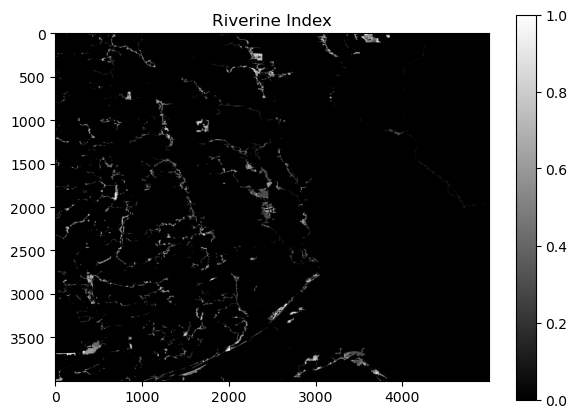

In [23]:
# plot riverine index
plt.figure(figsize=(7, 5))
plt.imshow(riverine_index, cmap="gray")
cbar = plt.colorbar()
plt.title("Riverine Index")

## Chopping the images into smaller chunks

In [24]:
print("landuse shape:", landuse.shape)
print("riverine_index shape:", riverine_index.shape)
print("BFE shape:", BFE.shape)
print("flood_index shape:", flood_index.shape)

landuse shape: (4000, 5000)
riverine_index shape: (4000, 5000)
BFE shape: (4000, 5000)
flood_index shape: (4000, 5000)


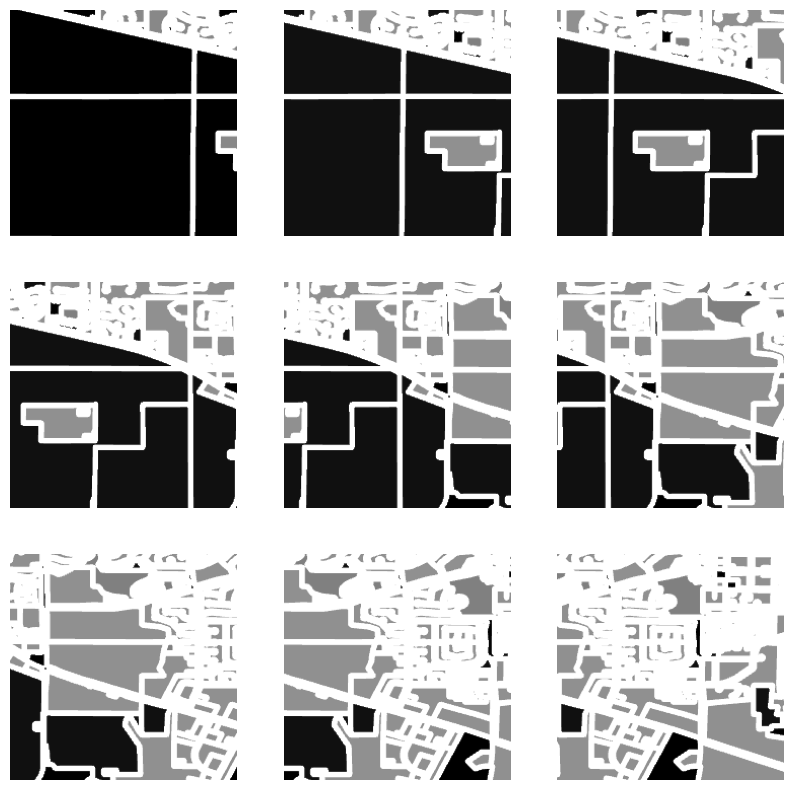

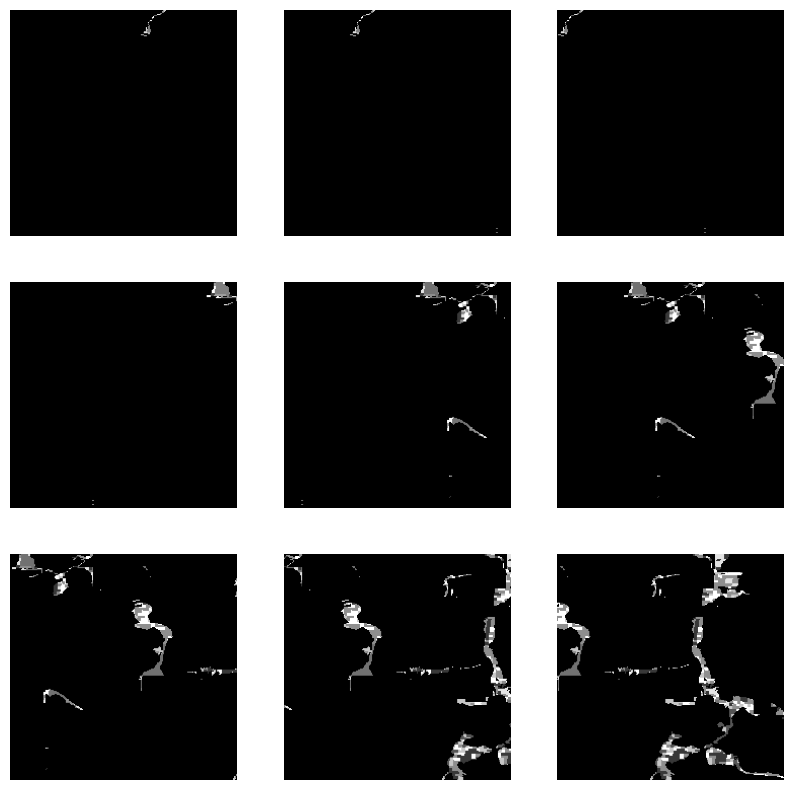

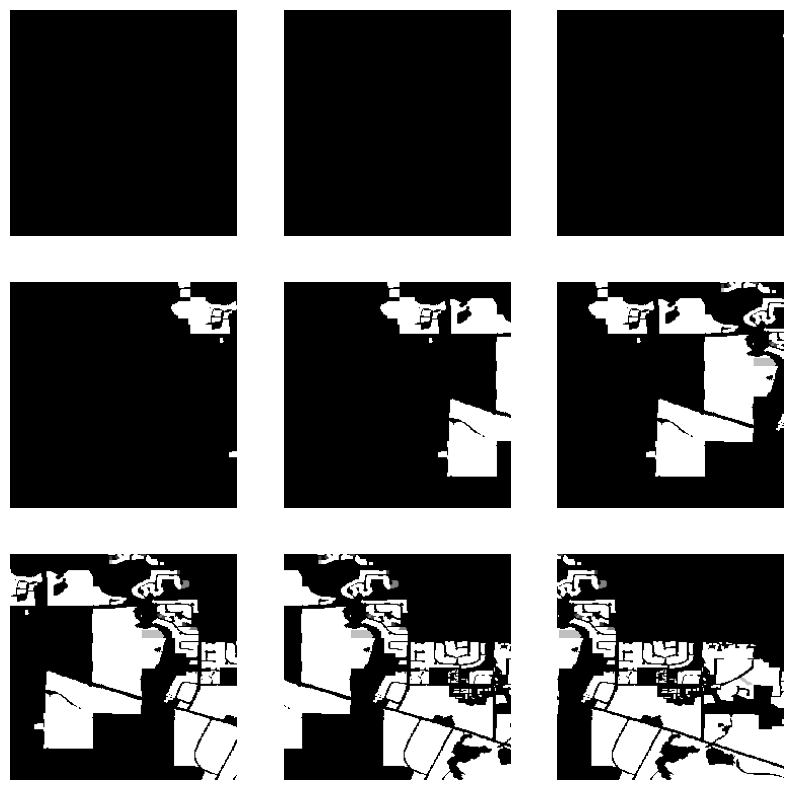

In [25]:
size = 224
step = 64


def get_patches(image, size, step):
    patches = []
    shp = (size, size)
    for i in range(0, image.shape[0], step):
        for j in range(0, image.shape[1], step):
            patch = image[i : i + size, j : j + size]
            if patch.shape != shp:
                diffx = size - patch.shape[0]
                diffY = size - patch.shape[1]
                patch = image[i - diffx : i + size, j - diffY : j + size]

            patches.append(patch)
    return patches


def plot_patches(patches, n):
    # plot first 9 patches
    fig, axes = plt.subplots(int(n**0.5), int(n**0.5), figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(patches[i], cmap="gray")
        ax.set_axis_off()


landuse_patches = get_patches(landuse, size, step)
riverine_index_patches = get_patches(riverine_index, size, step)
BFE_patches = get_patches(BFE, size, step)

plot_patches(landuse_patches, 9)
plot_patches(riverine_index_patches, 9)
plot_patches(BFE_patches, 9)

In [32]:
def multi_class_flood_patch(flood_masks, size, step):
    buffer = []
    for mask in flood_masks:
        buffer.append(get_patches(mask, size, step))

    flood_index_patches = []
    for i in range(len(buffer[0])):
        patches = []
        for j in range(len(buffer)):
            patches.append(buffer[j][i])
        patches = np.array(patches)
        flood_index_patches.append(patches)
    return flood_index_patches


flood_index_patches = multi_class_flood_patch(flood_masks, size, step)

In [34]:
print(len(flood_index_patches))
print(flood_index_patches[0].shape)
print(flood_index_patches[0].dtype)

4977
(10, 224, 224)
float32


## Creating Dataset from image chunks

### put the data in a pandas dataframe

In [35]:
# make a dataframe from the patches
df = pd.DataFrame()
df["landuse"] = landuse_patches
df["riverine_index"] = riverine_index_patches
df["BFE"] = BFE_patches
df["flood_index"] = flood_index_patches

# shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
# lenght of the dataframe
print(len(df))
# print flood_index datatype
print(type(df["flood_index"][0]))

4977
<class 'numpy.ndarray'>


### Create a custom Dataloader 

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        landuse = self.df.iloc[idx]["landuse"]
        riverine_index = self.df.iloc[idx]["riverine_index"]
        BFE = self.df.iloc[idx]["BFE"]
        flood_index = self.df.iloc[idx]["flood_index"]

        # reshape the data to (3, 512, 512)
        data = np.stack([landuse, riverine_index, BFE])

        # convert the data and labels to torch tensors
        data = torch.tensor(data)
        label = torch.tensor(flood_index)
        # label = torch.unsqueeze(label, 0)

        return data, label


# create the custom data loader
batch_size = 16
dataset = CustomDataset(df)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Check the data and label shapes for any mismatches

In [37]:
for i, batch in enumerate(dataloader):
    if i == 5:
        break
    data, label = batch
    print(data.shape)
    print(label.shape)
    print("-------------------------------------------")

torch.Size([16, 3, 224, 224])
torch.Size([16, 10, 224, 224])
-------------------------------------------
torch.Size([16, 3, 224, 224])
torch.Size([16, 10, 224, 224])
-------------------------------------------
torch.Size([16, 3, 224, 224])
torch.Size([16, 10, 224, 224])
-------------------------------------------
torch.Size([16, 3, 224, 224])
torch.Size([16, 10, 224, 224])
-------------------------------------------
torch.Size([16, 3, 224, 224])
torch.Size([16, 10, 224, 224])
-------------------------------------------


## Creating and Training Transformer Model

### Model Definition and testing

In [38]:
import segmentation_models_pytorch as smp
from torch.nn import functional as F

# Create a UNET model with segformer encoder
model = smp.Unet(
    encoder_name="mit_b0",  # specify the variant of ViT you want to use
    encoder_weights="imagenet",
    decoder_attention_type="scse",
    in_channels=3,
    classes=10,
    activation="sigmoid",
)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [100]:
# generate a random tensor to test the model
x = torch.randn(1, 3, 224, 224).to(device)
model = model.to(device)
output = model(x)
print(output.shape)

torch.Size([1, 10, 224, 224])


### Main Training Loop and saving the model

In [40]:
# Move the model to the device
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 50

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        # Move inputs and targets to the device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

Epoch 1/50, Loss: 132.93426996469498
Epoch 2/50, Loss: 76.2605177462101
Epoch 3/50, Loss: 64.50081576406956
Epoch 4/50, Loss: 58.55567152798176
Epoch 5/50, Loss: 54.88442403078079
Epoch 6/50, Loss: 52.037912495434284
Epoch 7/50, Loss: 49.68007256835699
Epoch 8/50, Loss: 47.937888123095036
Epoch 9/50, Loss: 46.77453462034464
Epoch 10/50, Loss: 45.437498189508915
Epoch 11/50, Loss: 44.67827349901199
Epoch 12/50, Loss: 44.65047783404589
Epoch 13/50, Loss: 43.33343704789877
Epoch 14/50, Loss: 42.55203750729561
Epoch 15/50, Loss: 42.22305866330862
Epoch 16/50, Loss: 41.9644385650754
Epoch 17/50, Loss: 41.82209375500679
Epoch 18/50, Loss: 41.57387740164995
Epoch 19/50, Loss: 40.86548043042421
Epoch 20/50, Loss: 40.650200963020325
Epoch 21/50, Loss: 40.398313745856285
Epoch 22/50, Loss: 40.024632669985294
Epoch 23/50, Loss: 39.86579945683479
Epoch 24/50, Loss: 39.33042969554663
Epoch 25/50, Loss: 39.87456838786602
Epoch 26/50, Loss: 39.034050568938255
Epoch 27/50, Loss: 38.68049059808254
Epoc

In [42]:
# save the model in the models folder
torch.save(model.state_dict(), "models/model_splitfloodmask_35loss.pth")

In [49]:
# Move the model to the device
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 50

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        # Move inputs and targets to the device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

Epoch 1/50, Loss: 35.940287701785564
Epoch 2/50, Loss: 35.66145569086075
Epoch 3/50, Loss: 35.40758344531059
Epoch 4/50, Loss: 35.95986230671406
Epoch 5/50, Loss: 35.28871484845877
Epoch 6/50, Loss: 35.46795216947794
Epoch 7/50, Loss: 35.38703631609678
Epoch 8/50, Loss: 36.00083454698324
Epoch 9/50, Loss: 34.937057100236416
Epoch 10/50, Loss: 34.76786092668772
Epoch 11/50, Loss: 34.87743552029133
Epoch 12/50, Loss: 34.53472667187452
Epoch 13/50, Loss: 34.515077248215675
Epoch 14/50, Loss: 34.740696117281914
Epoch 15/50, Loss: 34.461485758423805
Epoch 16/50, Loss: 34.416342325508595
Epoch 17/50, Loss: 34.386251233518124
Epoch 18/50, Loss: 34.200847670435905
Epoch 19/50, Loss: 33.80246473103762
Epoch 20/50, Loss: 33.8463385514915
Epoch 21/50, Loss: 33.908347472548485
Epoch 22/50, Loss: 33.63528709858656
Epoch 23/50, Loss: 33.76669578254223
Epoch 24/50, Loss: 34.101035475730896
Epoch 25/50, Loss: 34.48836551606655
Epoch 26/50, Loss: 33.82458030432463
Epoch 27/50, Loss: 33.71729528903961
E

In [157]:
# save the model in the models folder
torch.save(model.state_dict(), "models/model_splitfloodmask_32loss.pth")

## Calculate Accuracy of the Model

with Thresholding converting the output and target into binary

In [43]:
# write a accuracy function that calculates the accuracy of the model and takes the threshold as an argument
def accuracy(output, target, threshold):
    # flatten the output and target
    output = torch.flatten(output)
    target = torch.flatten(target)

    # convert the output to binary
    output = (output > threshold).float()
    # convert the target to binary
    target = (target > threshold).float()

    # calculate the accuracy
    correct = (output == target).float().sum()
    accuracy = correct / len(target)

    return accuracy

In [170]:
# iterate over the dataloader and calculate the accuracy
model.eval()
total_acc = 0
for inputs, targets in dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # calculate the accuracy
    acc = accuracy(outputs, targets, 0.5)
    total_acc += acc.item()

print(f"Accuracy: {total_acc/len(dataloader)}")

Accuracy: 0.9564651157229375


### Visualize the output compared to the input

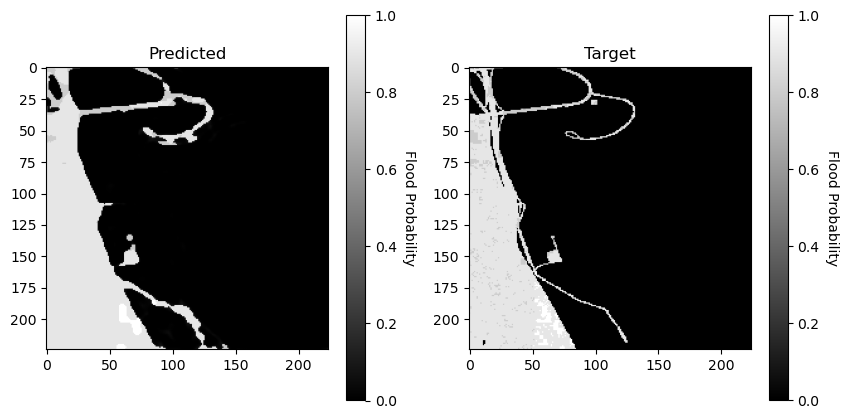

In [167]:
threshold = 0.1
# get a batch of data
inputs, targets = next(iter(dataloader))
model.to(device)
# move the data to the device
inputs = inputs.to(device)
targets = targets.to(device)


model.eval()
with torch.no_grad():
    outputs = model(inputs)
    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()
    
def flatten_target_n_output(outputs, targets, threshold):
    # Basically we have to flatten the the chanel dimension, but each channel has a different meaning
    # so we have to remeber which channel is which, edit each channel separately and then stack them back together
    # mask 0 is the lowest probability of flooding
    # mask 9 is the highest probability of flooding
    
    # flatten the target masks into one image
    for mask_index in range(10):
        target = np.squeeze(targets[:, mask_index, :, :])
        target[target > threshold] = 1 * (mask_index + 1) / 10
        targets[:, mask_index, :, :] = target

    # flatten the model output into one image
    # Algorithm picks the mask with the highest score (most sure about outcome) and 
    # multiplies it the the binarized thresholded flood risk probability
    # Resultant mask, is the most probable flood risk mask from the 10 masks
    max_mask_index = (np.argmax(outputs, axis=1) + 1) / 10
    outputs = np.max(outputs, axis=1)
    outputs[outputs > threshold] = 1
    outputs = outputs * max_mask_index

    targets = np.sum(targets, axis=1)
    return outputs, targets

outputs, targets = flatten_target_n_output(outputs, targets, threshold)


def plot_outputs_targets(outputs, targets):
    # plot outputs and targets
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(outputs[0], cmap="gray")
    axes[0].set_title("Predicted")
    # add colorbar
    cbar = axes[0].figure.colorbar(axes[0].imshow(outputs[0], cmap="gray"), ax=axes[0])
    cbar.ax.set_ylabel("Flood Probability", rotation=-90, va="bottom")
    axes[1].imshow(targets[0], cmap="gray")
    axes[1].set_title("Target")
    # add colorbar
    cbar = axes[1].figure.colorbar(axes[1].imshow(targets[0], cmap="gray"), ax=axes[1])
    cbar.ax.set_ylabel("Flood Probability", rotation=-90, va="bottom")

plot_outputs_targets(outputs, targets)

## Visualizing Attention Blocks

In [175]:
# # Now you can use the model just like any other PyTorch model
# get a batch of data
inputs, targets = next(iter(dataloader))
# move the data to the device
inputs = inputs.to(device)
targets = targets.to(device)
outputs = model(inputs)

# getting the attention scores
# forward pass
x = inputs
data = x

# fetching all the references
mixformer = model.encoder
block = mixformer.block1[0]
attention_block = block.attn
embeddings = mixformer.patch_embed1

# Getting embeddings
x, H, W = embeddings(x)
print(H, W)
print(x.shape)

# Normalize the input
x_norm = block.norm1(x)

# calculate the query, key and value
B, N, C = x.shape
q = (
    attention_block.q(x)
    .reshape(B, N, attention_block.num_heads, C // attention_block.num_heads)
    .permute(0, 2, 1, 3)
)

if attention_block.sr_ratio > 1:
    x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
    x_ = attention_block.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
    x_ = attention_block.norm(x_)
    kv = (
        attention_block.kv(x_)
        .reshape(B, -1, 2, attention_block.num_heads, C // attention_block.num_heads)
        .permute(2, 0, 3, 1, 4)
    )
else:
    kv = (
        attention_block.kv(x)
        .reshape(B, -1, 2, attention_block.num_heads, C // attention_block.num_heads)
        .permute(2, 0, 3, 1, 4)
    )
k, v = kv[0], kv[1]

# calculate the attention
attn = (q @ k.transpose(-2, -1)) * attention_block.scale
attn = attn.softmax(dim=-1)
print(attn.shape)

56 56
torch.Size([16, 3136, 32])
torch.Size([16, 1, 3136, 49])


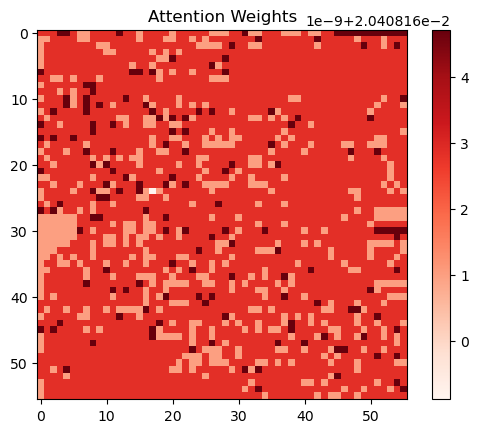

In [176]:
# Reshape the attention weights to the original height and width
attn_reshaped = attn.reshape(B, attention_block.num_heads, H, W, -1)

# Take the mean over the last dimension
attn_reshaped = attn_reshaped.mean(dim=-1)
attn_reshaped = attn_reshaped.detach().cpu().numpy()
# Visualize the attention weights for the first image in the batch
plt.imshow(attn_reshaped[0][0], cmap="Reds")
plt.title("Attention Weights")
plt.colorbar()
plt.show()

In [177]:
# Reshape the attention weights to the original height and width
attn_reshaped = attn.reshape(B, attention_block.num_heads, H, W, -1)

# Take the mean over the last dimension
attn_reshaped = attn_reshaped.mean(dim=-1)
weights_reshaped = F.interpolate(
    attn_reshaped, size=(224, 224), mode="bilinear", align_corners=False
)

# convert the data to numpy arrays
data = data.detach().cpu().numpy()
targets = targets.detach().cpu().numpy()
outputs = outputs.detach().cpu().numpy()
outputs, targets = flatten_target_n_output(outputs, targets, 0.1)
weights_reshaped = weights_reshaped.detach().cpu().numpy()

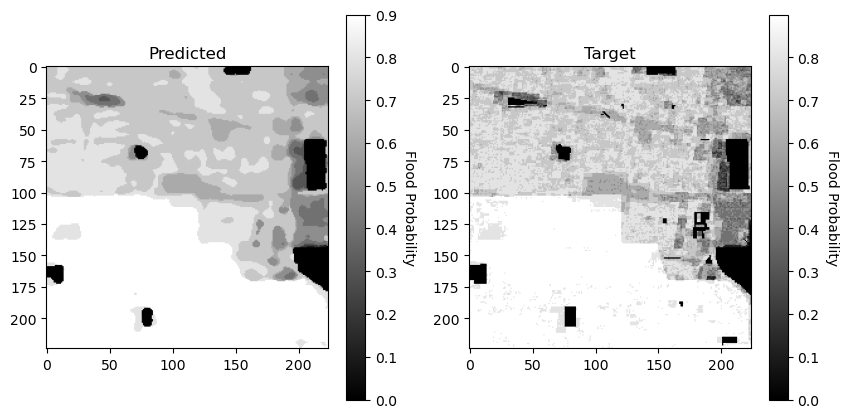

In [178]:
plot_outputs_targets(outputs, targets)

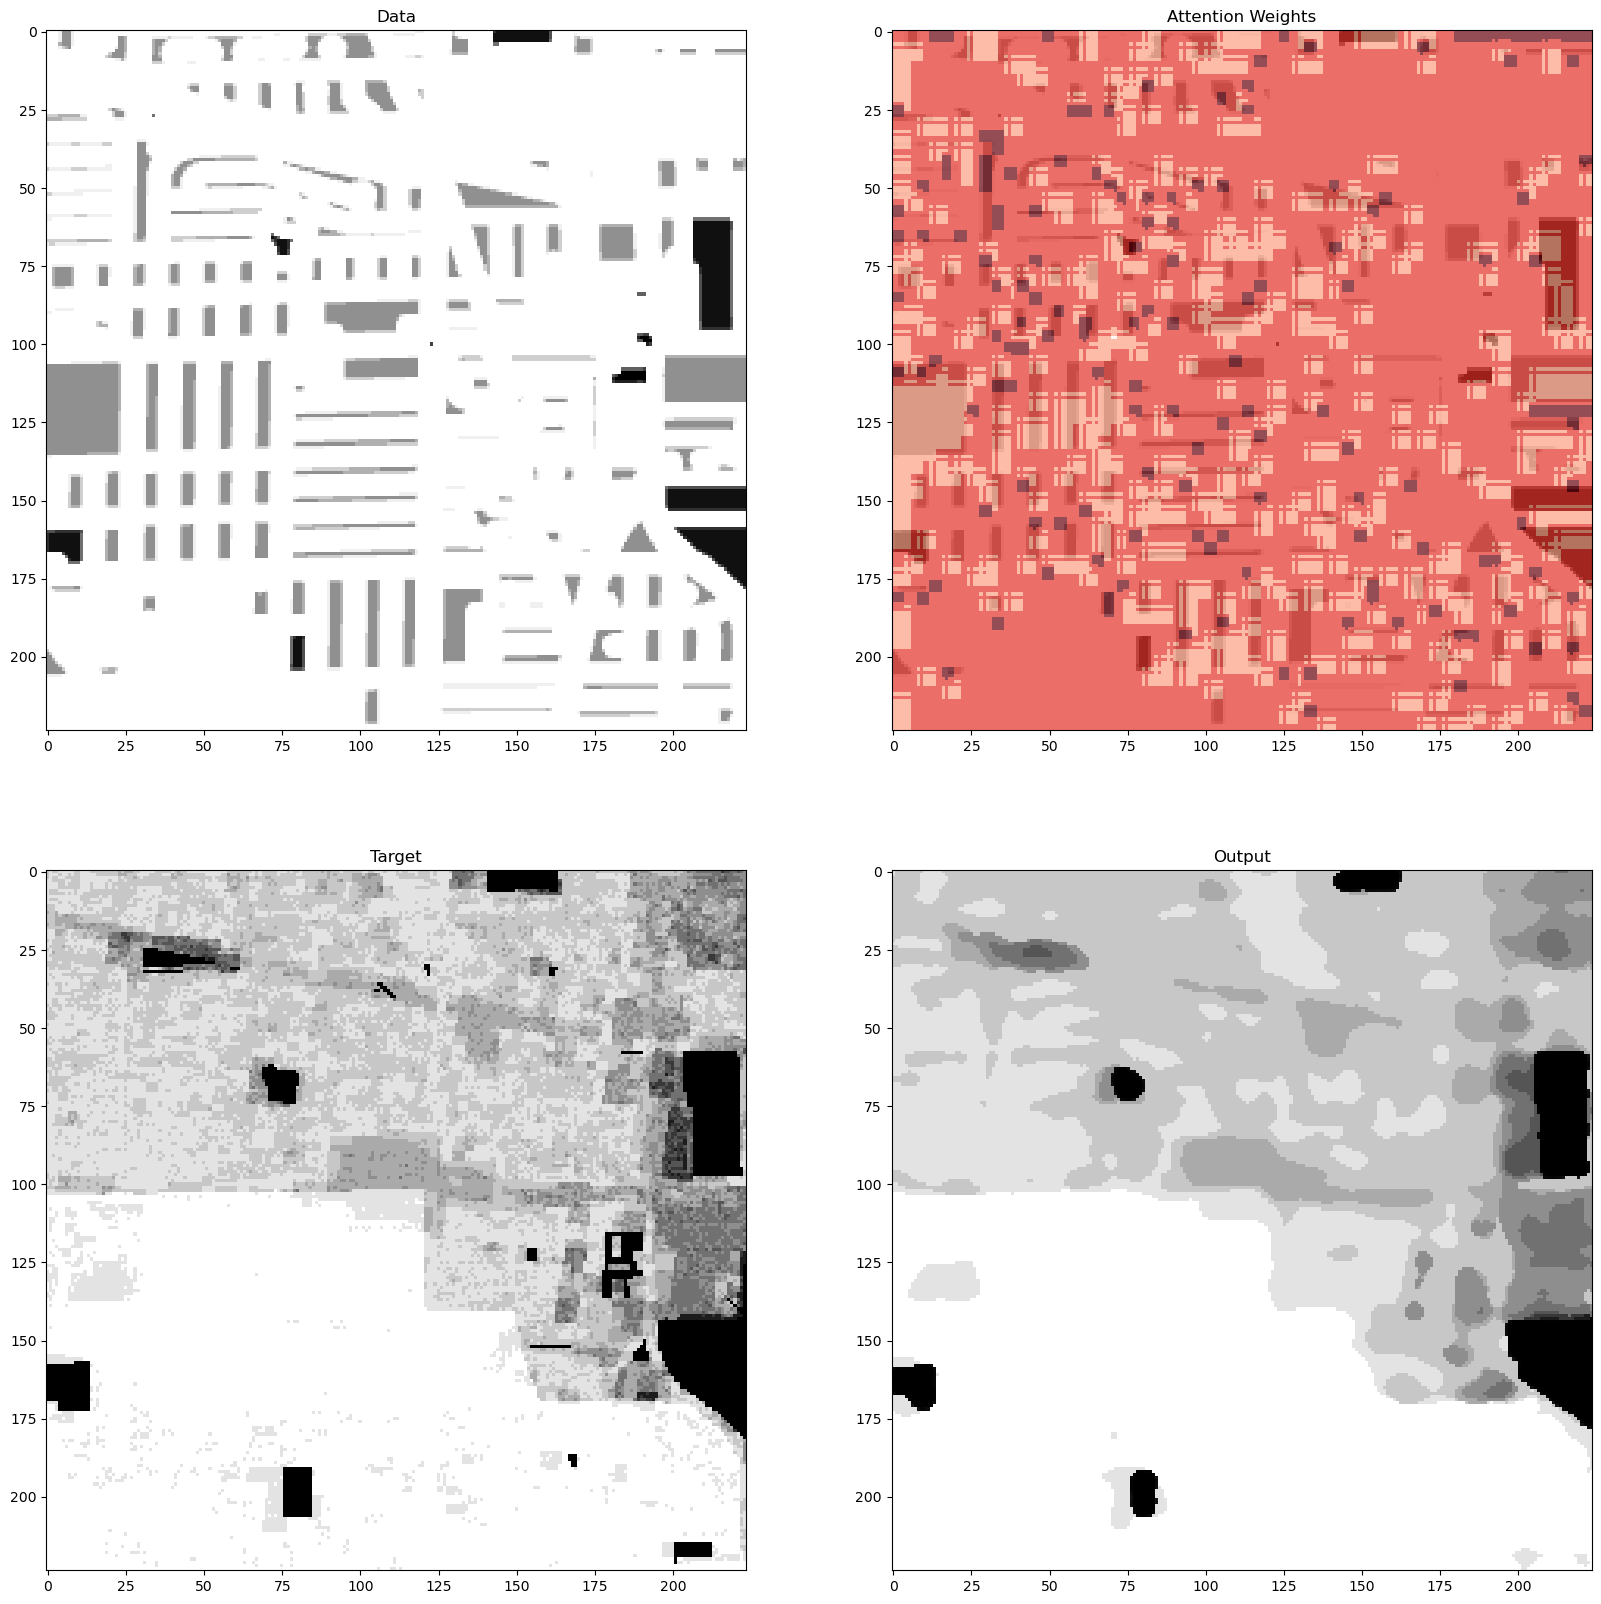

In [179]:
# plot data targets and outputs and weights reshaped
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes[0][0].imshow(data[0][0], cmap="gray")
axes[0][0].set_title("Data")

axes[0][1].imshow(data[0][0], cmap="gray")
axes[0][1].imshow(weights_reshaped[0][0], cmap="Reds", alpha=0.7)
axes[0][1].set_title("Attention Weights")

axes[1][0].imshow(targets[0], cmap="gray")
axes[1][0].set_title("Target")

axes[1][1].imshow(outputs[0], cmap="gray")
axes[1][1].set_title("Output")

plt.show()